# Using SpatioTemporal Asset Catalog (STAC) in Python

## Python environment & libraries

You will use several functions from [eumap](https://eumap.readthedocs.io), a library developed in the context of [Open Data Science Europe (ODSE)](https://opendatascience.eu/) that can be installed through [Conda/Pip](https://eumap.readthedocs.io/en/latest/index.html#conda) or used directly inside the Docker container [opengeohub/pygeo-ide](https://hub.docker.com/r/opengeohub/pygeo-ide).

In **Google Colab** use the following line to install eumap properly and the [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/):

In [ ]:
!pip install -e 'git+https://gitlab.com/geoharmonizer_inea/eumap.git@colab_deps#egg=eumap[full]'
!pip install ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining eumap[full] from git+https://gitlab.com/geoharmonizer_inea/eumap.git@colab_deps#egg=eumap[full]
  Cloning https://gitlab.com/geoharmonizer_inea/eumap.git (to revision colab_deps) to ./src/eumap
  Running command git clone -q https://gitlab.com/geoharmonizer_inea/eumap.git /content/src/eumap
  Running command git checkout -b colab_deps --track origin/colab_deps
  Switched to a new branch 'colab_deps'
  Branch 'colab_deps' set up to track remote branch 'colab_deps' from 'origin'.
     |████████████████████████████████| 962 kB 7.8 MB/s 
     |████████████████████████████████| 6.6 MB 33.8 MB/s 
     |████████████████████████████████| 202 kB 36.2 MB/s 
     |████████████████████████████████| 10.5 MB 32.5 MB/s 
     |████████████████████████████████| 15.1 MB 61 kB/s 
     |████████████████████████████████| 1.2 MB 40.5 MB/s 
     |████████████████████████████████| 11.2 MB 22.8 MB/s 
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 12.3 MB/s 


Considering that the dataset used by the tutorial will be retrieved directly from the [ODSE SpatioTemporal Asset Catalog (STAC)](https://stac.opendatascience.eu/), it's necessary install the [pystac library](https://pystac.readthedocs.io/en/stable/index.html):

In [ ]:
!pip install pystac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 28.3 MB/s 


You need also to install [Whoosh](https://whoosh.readthedocs.io/en/latest/intro.html), a fast, pure Python search engine library that will allow you to build a local search index for the STAC layers. 

In [ ]:
pip install whoosh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 468 kB 29.6 MB/s 


After that, let's import some python modules / functions

In [ ]:
from pathlib import Path
import numpy as np
import rasterio

from eumap.raster import read_rasters, save_rasters
from eumap import plotter 
from eumap.misc import ttprint

import pystac

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


... and create catalog instance pointing to ODSE STAC.

In [ ]:
STAC_URL = 'https://s3.eu-central-1.wasabisys.com/stac/odse/catalog.json'
catalog = pystac.Catalog.from_file(STAC_URL)

## Search Index

In [ ]:
def whoosh_index(catalog, index_dir = 'stac_index'):    
    from whoosh.index import create_in
    from whoosh import fields
    
    Path(index_dir).mkdir(parents=True, exist_ok=True)
    ix = create_in(index_dir, fields.Schema(title=fields.TEXT(stored=True), 
                                                 path=fields.ID(stored=True), description=fields.TEXT))
    
    ttprint(f'Retriving all collections from {catalog.title}')
    collections = list(catalog.get_collections())
    
    ttprint(f'Creating index for {len(collections)} collections')
    writer = ix.writer()
    for collection in collections:
        writer.add_document(
            title=collection.title, 
            path=collection.id, 
            description=collection.title + ' ' + collection.description
        )

    writer.commit()
    
    return ix

In [ ]:
ix = whoosh_index(catalog)

[01:27:29] Retriving all collections from OpenDataScience Europe
[01:28:13] Creating index for 133 collections


In [ ]:
def whoosh_search(ix, query, field='title'):
    from whoosh.qparser import QueryParser
    
    result = []
    with ix.searcher() as searcher:
        parser = QueryParser(field, ix.schema)
        myquery = parser.parse(query)
        
        i = 0
        for r in searcher.search(myquery):
            result.append({
                'pos': i,
                'path': r['path'],
                'title': r['title']
            })
            i += 1
    
    return result

In [ ]:
result = whoosh_search(ix, 'Forest*')
result

[{'path': 'lcv_forest_osm', 'pos': 0, 'title': 'OSM Forest'},
 {'path': 'lcv_landcover.244_lucas.corine.eml',
  'pos': 1,
  'title': 'Annual agro-forestry areas at 30 m (2000–2020)'},
 {'path': 'lcv_landcover.312_lucas.corine.eml',
  'pos': 2,
  'title': 'Annual coniferous forest at 30 m (2000–2020)'},
 {'path': 'lcv_landcover.313_lucas.corine.eml',
  'pos': 3,
  'title': 'Annual mixed forest at 30 m (2000–2020)'},
 {'path': 'lcv_landcover.311_lucas.corine.eml',
  'pos': 4,
  'title': 'Annual broad-leaved forest at 30 m (2000–2020)'}]

## Collection items and assets

In [ ]:
collection_id = result[2]['path']
collection_first_item = next(catalog.get_child(collection_id).get_all_items())
collection_first_item

<Item id=lcv_landcover.312_lucas.corine.eml_2000.01.01..2000.12.31>

In [ ]:
for key, item in collection_first_item.get_assets().items():
    print(f'- {key}: {item}')

- landcover.312_lucas.corine.eml_p_0..0cm: <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.312_lucas.corine.eml_p_30m_0..0cm_2000_eumap_epsg3035_v0.2.tif>
- landcover.312_lucas.corine.eml_md_0..0cm: <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.312_lucas.corine.eml_md_30m_0..0cm_2000_eumap_epsg3035_v0.2.tif>
- thumbnail: <Asset href=https://s3.eu-central-1.wasabisys.com/stac/odse/lcv_landcover.312_lucas.corine.eml/lcv_landcover.312_lucas.corine.eml_2000.01.01..2000.12.31/lcv_landcover.312_lucas.corine.eml_p_30m_0..0cm_2000_eumap_epsg3035_v0.2.png>
- landcover.312_lucas.corine.eml_md_0..0cm_preview: <Asset href=https://s3.eu-central-1.wasabisys.com/stac/odse/lcv_landcover.312_lucas.corine.eml/lcv_landcover.312_lucas.corine.eml_2000.01.01..2000.12.31/lcv_landcover.312_lucas.corine.eml_md_30m_0..0cm_2000_eumap_epsg3035_v0.2.png>


### Thumbnail

In [ ]:
def thumbnail_grid(collection, ncols = 4, figsize=(15, 25), axes_pad=(0,0.4)):
    import math
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid

    items = list(collection.get_all_items())

    nrows = math.ceil(len(items) / 4)

    fig = plt.figure(figsize=figsize)
    fig.tight_layout()
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=axes_pad)

    for ax, item in zip(grid, items):
        thumbnail_url = item.assets['thumbnail'].href

        start_dt = item.properties['start_datetime']
        end_dt = item.properties['end_datetime']
        title = f'{start_dt} - {end_dt}'

        ax.title.set_text(title)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])

        im = plt.imread(thumbnail_url)
        ax.imshow(im)

    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.


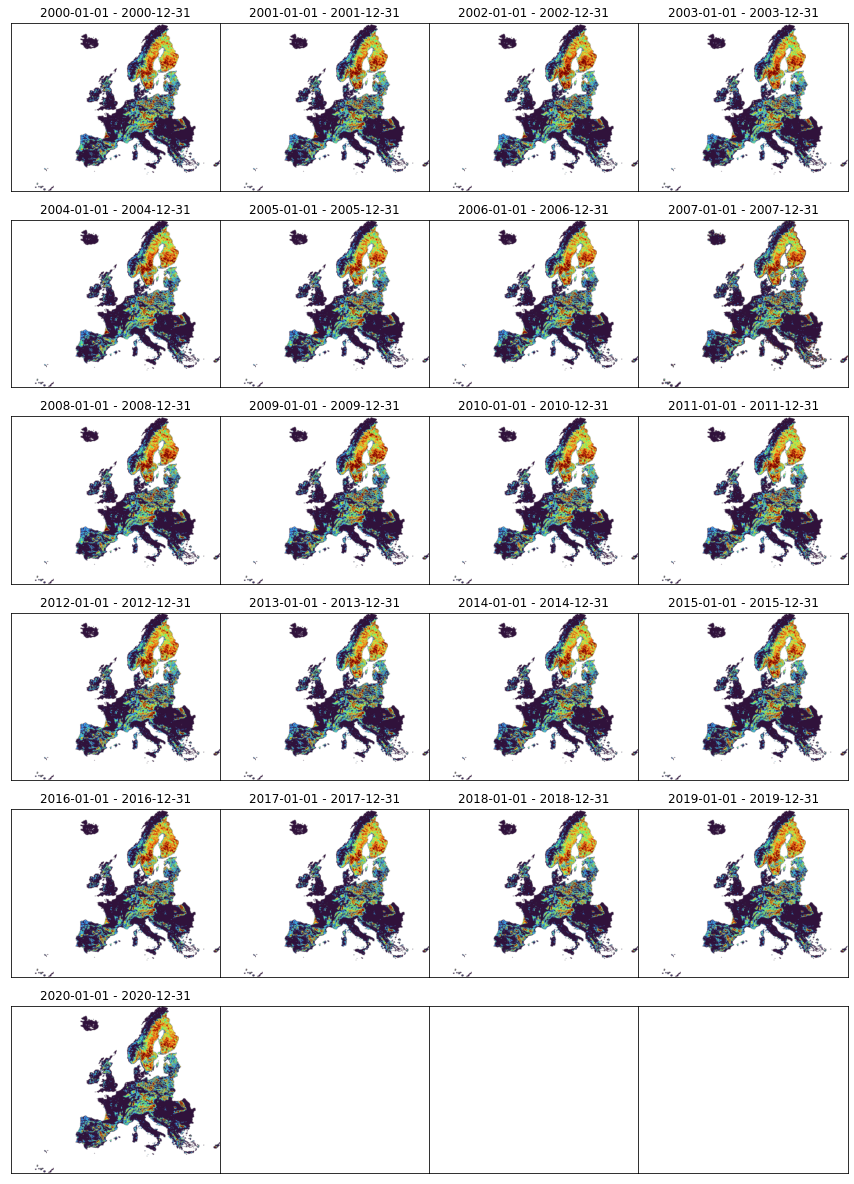

In [ ]:
thumbnail_grid(catalog.get_child(collection_id))

In [ ]:
def cog_urls(collection, asset_id):
    return [ item.assets[asset_id].href for item in collection.get_all_items() ]

def items_props(collection):
    return [ item.properties for item in collection.get_all_items() ]

In [ ]:
collection_urls = cog_urls(catalog.get_child(collection_id), 'landcover.312_lucas.corine.eml_p_0..0cm')

print(f'First URL: {collection_urls[0]}')
print(F'Last URL: {collection_urls[len(collection_urls)-1]}')

First URL: https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.312_lucas.corine.eml_p_30m_0..0cm_2000_eumap_epsg3035_v0.2.tif
Last URL: https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.312_lucas.corine.eml_p_30m_0..0cm_2020_eumap_epsg3035_v0.2.tif


In [ ]:
collection_props = items_props(catalog.get_child(collection_id))

import json
print(f'First properties: {json.dumps(collection_props[0], indent=4, sort_keys=True)}')
print(F'Last properties: {json.dumps(collection_props[len(collection_props)-1], indent=4, sort_keys=True)}')

First properties: {
    "datetime": "2000-01-01T00:00:00Z",
    "end_datetime": "2000-12-31",
    "gsd": "30",
    "instruments": [
        "TM",
        "ETM+",
        "OLI"
    ],
    "platform": "landsat",
    "start_datetime": "2000-01-01"
}
Last properties: {
    "datetime": "2020-01-01T00:00:00Z",
    "end_datetime": "2020-12-31",
    "gsd": "30",
    "instruments": [
        "TM",
        "ETM+",
        "OLI"
    ],
    "platform": "landsat",
    "start_datetime": "2020-01-01"
}


## COG overviews

In [ ]:
def read_overview(cog_url, level=3):
    with rasterio.open(cog_url) as src:
        # List of overviews from biggest to smallest
        oviews = src.overviews(1)
        print(f'Overviews: {oviews}')
        oview = oviews[level]

        return src.read(1, out_shape=(1, src.height // oview, src.width // oview)), src.nodata
    
ovr_2000, ovr_nodata = read_overview(collection_urls[0], level=7)
print(ovr_2000.shape)

Overviews: [2, 4, 8, 16, 32, 64, 128, 256]
(589, 734)


https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.312_lucas.corine.eml_p_30m_0..0cm_2000_eumap_epsg3035_v0.2.tif


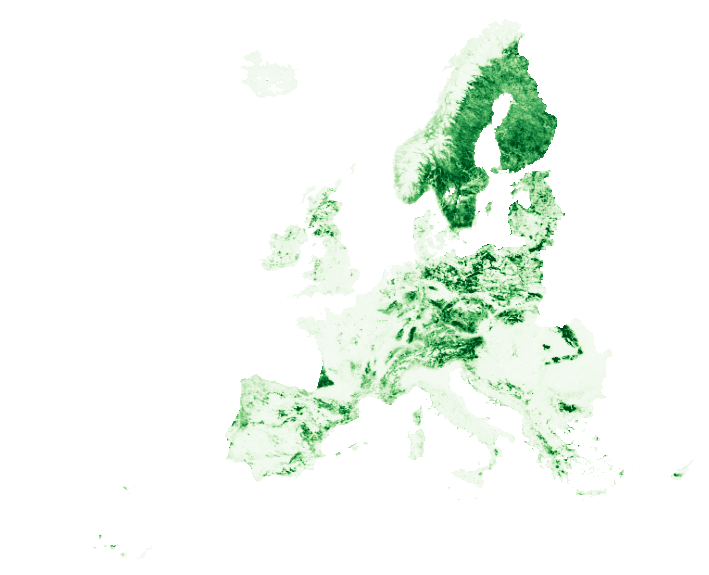

In [ ]:
from eumap import plotter
print(collection_urls[0])
plotter.plot_rasters(ovr_2000, figsize=6, cmaps='Greens', nodata=ovr_nodata, vmin=0, vmax=50)

Overviews: [2, 4, 8, 16, 32, 64, 128, 256]
Overviews: [2, 4, 8, 16, 32, 64, 128, 256]


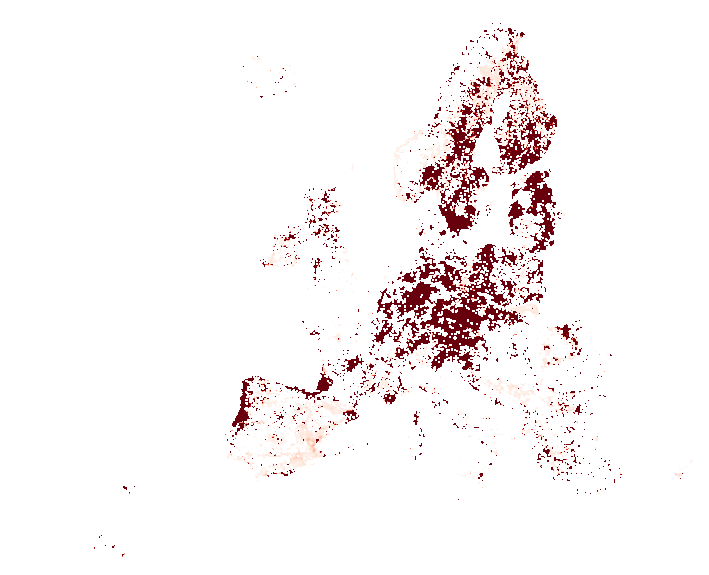

In [ ]:
level = 7
ovr_data_2000, ovr_nodata_2000 = read_overview(collection_urls[0], level=level)
ovr_data_2020, ovr_nodata_2020 = read_overview(collection_urls[len(collection_urls)-1], level=level)
diff = ovr_data_2020 - ovr_data_2000

plotter.plot_rasters(diff, figsize=6, cmaps='Reds', nodata=ovr_nodata_2020, vmin=0, vmax=100)

## Assets access

To demonstrate COG reads and writes, let's first make an interactive map with `ipyleaflet` that we'll use to select a bounding box around Wageningen. We can define a `DrawControl` and add it to the map controls.

In [ ]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 4, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

We can now select the feature from `DrawControl.data` and get its bounds.

In [ ]:
from shapely.geometry import shape
geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds
bounds

(5.437546, 51.920556, 5.772629, 52.063468)

`ipyleaflet.DrawControl` defines geometries in the WGS84 CRS, so we'll first transform them to ETRS89/LAEA before we can define a `Window` to read the COG.

In [ ]:
from pyproj import Transformer
from rasterio.windows import Window, from_bounds

base_raster = rasterio.open(collection_urls[0])

transformer = Transformer.from_crs("epsg:4326", base_raster.crs, always_xy=True)
left, bottom = transformer.transform(bounds[0], bounds[1])
right, top = transformer.transform(bounds[2], bounds[3])

window = from_bounds(left, bottom, right, top, base_raster.transform)
print(f'left={left}, bottom={bottom}, right={right}, top={top}')
print(f'window = {window}')

left=4007342.4750108747, bottom=3210978.832030329, right=4031270.870186194, top=3225468.6391858133
window = Window(col_off=103578.08250036248, row_off=74484.71202713957, width=797.6131725106388, height=482.99357184948167)


With the newly defined window we can quickly read directly from a large COG file stored in our ODSE STAC.

[01:30:59] Reading 21 raster files using 4 workers


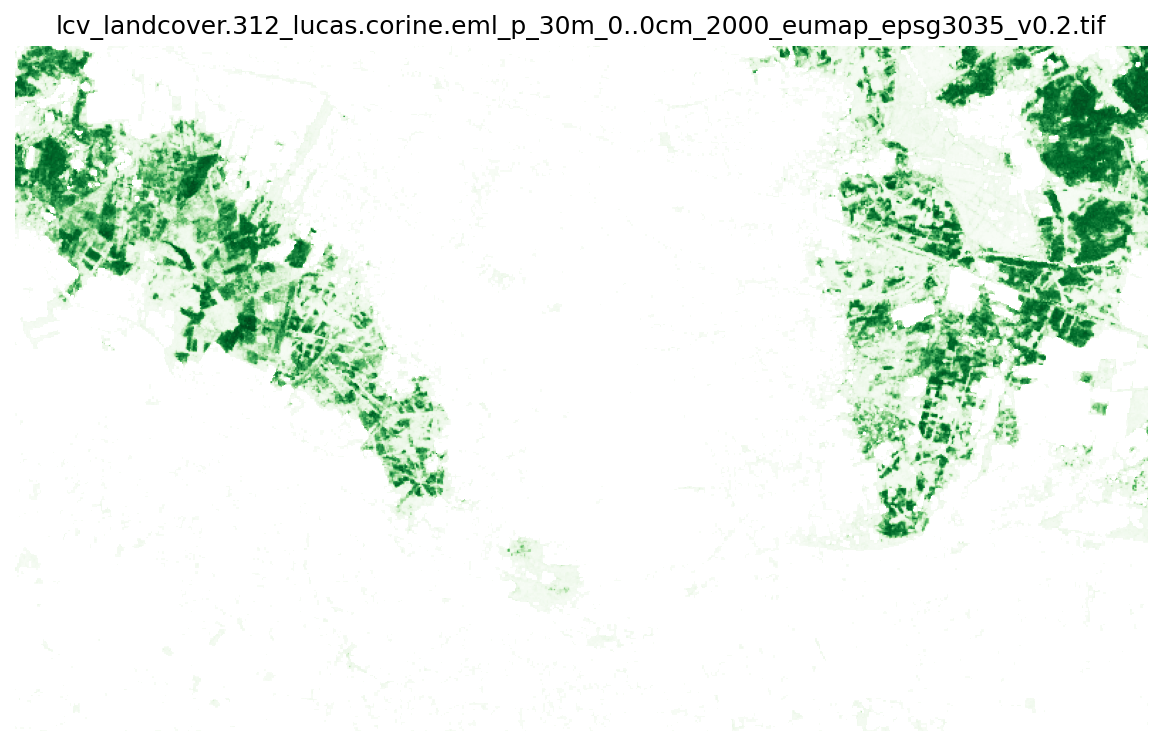

In [ ]:
from eumap.raster import read_rasters, save_rasters
cog_url = collection_urls[0]

data, _ = read_rasters(raster_files=collection_urls, spatial_win=window, verbose=True)
plotter.plot_rasters(data[:,:,0].astype('float32'), cmaps="Greens", nodata=ovr_nodata, titles=[ Path(cog_url).name ])

Using `eumap.raster.save_rasters` we can save the clipped data by passing the COG as the reference file along with the window definition.

In [ ]:
roi_label = 'Wageningen'
workdir = Path('ODSE_workdir')
fn_rasters = [ workdir.joinpath(collection_id).joinpath(roi_label).joinpath(Path(url).name) for url in collection_urls ]
fn_rasters = save_rasters(fn_base_raster=collection_urls[0], fn_raster_list=fn_rasters, data=data, spatial_win=window, verbose=True)

[01:31:55] Writing 21 raster files using 4 workers


## Time series access

Similarly, we can use the efficient structure of COG files to read a time series at a single point from multiple large files at once. Let's make an interactive map again, this time to pick a location by drawing a point marker

In [ ]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl, basemap_to_tiles

mapnik = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
mapnik.base = True
mapnik.name = 'Mapnik Layer'

esri = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri.base = True
esri.name = 'ESRI Imagery Layer'

m = Map(center=(51.98, 5.65), zoom = 5, layers=[esri, mapnik])

draw_control = DrawControl()
draw_control.point = {
    "shapeOptions": {
        "fillColor": "#ff0000",
        "color": "#ffffff",
        "fillOpacity": 0.6,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

...and again select the geometry from the `DrawControl`.

In [ ]:
from shapely.geometry import shape
geometry = shape(draw_control.data[-1]['geometry'])
geometry.x, geometry.y

(6.041815, 52.078807)

Once more we have to transform the geometry from WGS84 to ETRS89/LAEA.

In [ ]:
from pyproj import Transformer
from rasterio.windows import Window, from_bounds

base_raster = rasterio.open(collection_urls[0])

transformer = Transformer.from_crs("epsg:4326", base_raster.crs, always_xy=True)
lon_3035, lat_3035 = transformer.transform(geometry.x, geometry.y)
print(lon_3035, lat_3035)

4049791.1021041465 3226136.8913695496


We can now use the point coordinates to sample the dataset with `rasterio`.

In [ ]:
cog_url = collection_urls[0]
with rasterio.open(cog_url) as ds:
    pixel_val = next(ds.sample([(lon_3035, lat_3035)]))
    print(pixel_val)

[84]


We will define an argument list and a worker function that takes a raster url and point coordinates as arguments

In [ ]:
from eumap import parallel
from pathlib import Path
import pandas as pd
import numpy as np

def read_pixel(cog_url, props, coordinates):
    pixel_val = None
    
    try:
        with rasterio.open(cog_url) as ds:
            pixel_val = np.stack(ds.sample(coordinates))
    except Exception as e:
        print(e, 'at coordinates', coordinates)
    return pixel_val

def run(lon, lat, urls, properties_list):
    result = []

    args = [ (cog_url, props, [ (lon, lat) ] ) for cog_url, props in zip(urls, properties_list) ] 

    for arg, pixel_vals in zip(args, parallel.job(read_pixel, args, n_jobs=-1)):

        raster_name = Path(arg[0]).name
        props = arg[1]
        cordinates = arg[2]
        
        for i in range(0, len(cordinates)):
            lon, lat = cordinates[i]
            result.append({
                'raster_name': raster_name,
                'start_date': props['start_datetime'],
                'end_date': props['end_datetime'],
                'lon': lon,
                'lat': lat, 
                'value': float(pixel_vals[i][0])
            })

    return pd.DataFrame(result)

...and use `eumap` to run the sampling in parallel, and then construct a `DataFrame` from the results.

In [ ]:
collection_urls_md = cog_urls(catalog.get_child(collection_id), 'landcover.312_lucas.corine.eml_md_0..0cm')

df_ts = run(lon_3035, lat_3035, collection_urls, collection_props)
df_ts_md = run(lon_3035, lat_3035, collection_urls_md, collection_props)
df_ts

,raster_name,start_date,end_date,lon,lat,value
0,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2000-01-01,2000-12-31,4.049791e+06,3.226137e+06,84.0
1,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2001-01-01,2001-12-31,4.049791e+06,3.226137e+06,84.0
2,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2002-01-01,2002-12-31,4.049791e+06,3.226137e+06,80.0
3,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2003-01-01,2003-12-31,4.049791e+06,3.226137e+06,85.0
4,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2004-01-01,2004-12-31,4.049791e+06,3.226137e+06,89.0
5,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2005-01-01,2005-12-31,4.049791e+06,3.226137e+06,84.0
6,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2006-01-01,2006-12-31,4.049791e+06,3.226137e+06,87.0
7,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2007-01-01,2007-12-31,4.049791e+06,3.226137e+06,85.0
8,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2008-01-01,2008-12-31,4.049791e+06,3.226137e+06,83.0
9,lcv_landcover.312_lucas.corine.eml_p_30m_0..0c...,2009-01-01,2009-12-31,4.049791e+06,3.226137e+06,82.0


We can now plot the time series.

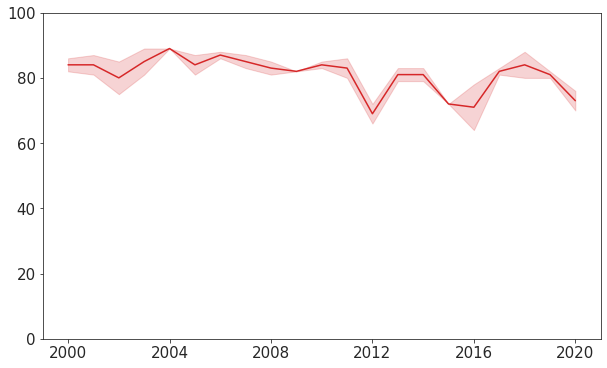

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style("ticks")
matplotlib.rcParams.update({'font.size': 15})
myfig, myax = plt.subplots(figsize=(10, 6))
myax.plot(pd.to_datetime(df_ts['start_date'], format='%Y-%m-%d'), df_ts['value'], color='tab:red', linestyle='-')

low = df_ts['value'] - df_ts_md['value']
upp = df_ts['value'] + df_ts_md['value']
myax.fill_between(pd.to_datetime(df_ts_md['start_date'], format='%Y-%m-%d'), low, upp, color='tab:red', alpha=0.2)

plt.ylim(0,100)

myax.grid(False)
fmt_half_year = mdates.MonthLocator(interval=29)